🌍 Earthquake Magnitude Prediction: End-to-End Analysis (EDA + Modeling)

In [1]:
#1. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import datetime
import geopy
from scipy.interpolate import interpolate
from tqdm import tqdm 
from shapely.geometry import Point
import geopandas as gpd
import geodatasets
import seaborn as sns
import warnings
import pytz
warnings.filterwarnings('ignore')

In [2]:
# 2. Load Dataset
file_path = 'seismic_gap_clean.csv'  
df = pd.read_csv(file_path)

In [3]:
# 3. Tampilkan Ringkasan Data

print(df.info())
print("Jumlah data:", len(df))
print("\nKolom yang tersedia:")
print(df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64947 entries, 0 to 64946
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      64947 non-null  float64
 1   longitude     64947 non-null  float64
 2   depth         64947 non-null  float64
 3   mag           64947 non-null  float64
 4   magType       64947 non-null  object 
 5   rms           64947 non-null  float64
 6   net           64947 non-null  object 
 7   id            64947 non-null  object 
 8   updated       64947 non-null  object 
 9   place         64947 non-null  object 
 10  type          64947 non-null  object 
 11  status        64947 non-null  object 
 12  magSource     64947 non-null  object 
 13  year          64947 non-null  int64  
 14  month         64947 non-null  int64  
 15  day           64947 non-null  int64  
 16  mag_category  64927 non-null  object 
 17  lat_bin       64947 non-null  float64
 18  lon_bin       64947 non-nu

In [4]:
#4. Hapus Anomali Data

print("\nDuplikasi data:")
print(df[df.duplicated()].index)
# Hapus duplikat atau lakukan penyesuaian sesuai kebutuhan

#6. Filter Berdasarkan Lokasi Indonesia

mask = (df['latitude'] >= -11) & (df['latitude'] <= 6) & (df['longitude'] >= 95) & (df['longitude'] <= 141)
df = df[mask]
print("Data setelah filtering lokasi Indonesia:")
print(len(df))



Duplikasi data:
Index([], dtype='int64')
Data setelah filtering lokasi Indonesia:
64947


B. Visualisasi Tempooral

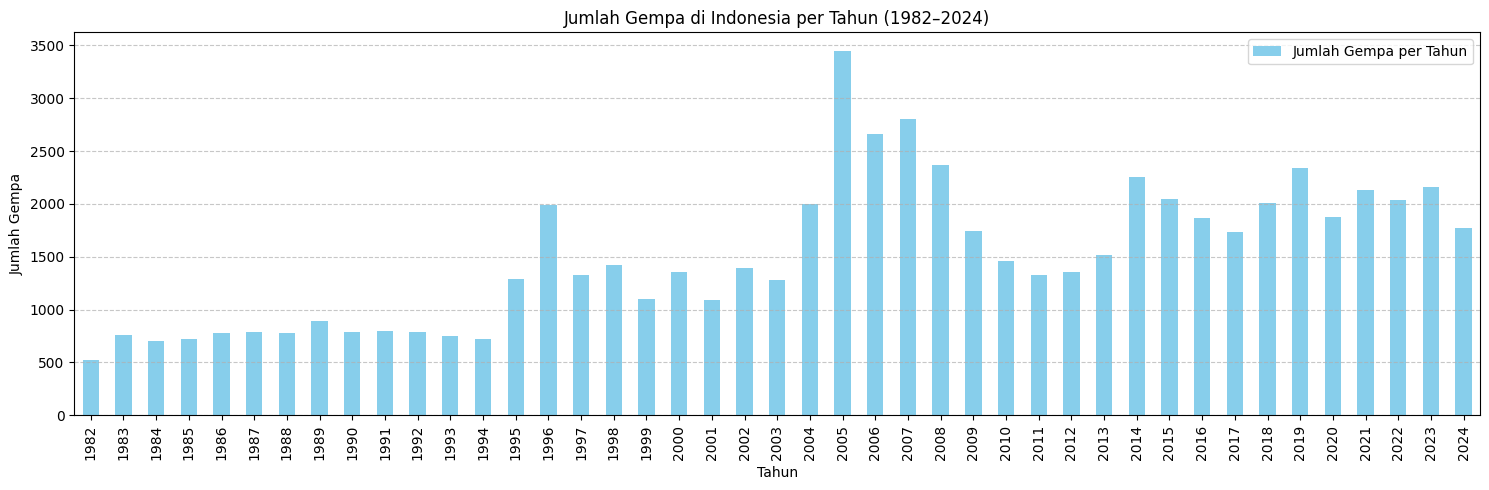

In [5]:
#1. Jumlah Gempa per Tahun

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# Hitung jumlah gempa per tahun dan urutkan berdasarkan tahun (bukan jumlah gempa)
counts = df.groupby('year')['mag'].count().sort_index()

# Plot
counts.plot(kind='bar', color='skyblue', label='Jumlah Gempa per Tahun')

plt.title('Jumlah Gempa di Indonesia per Tahun (1982–2024)')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Gempa')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

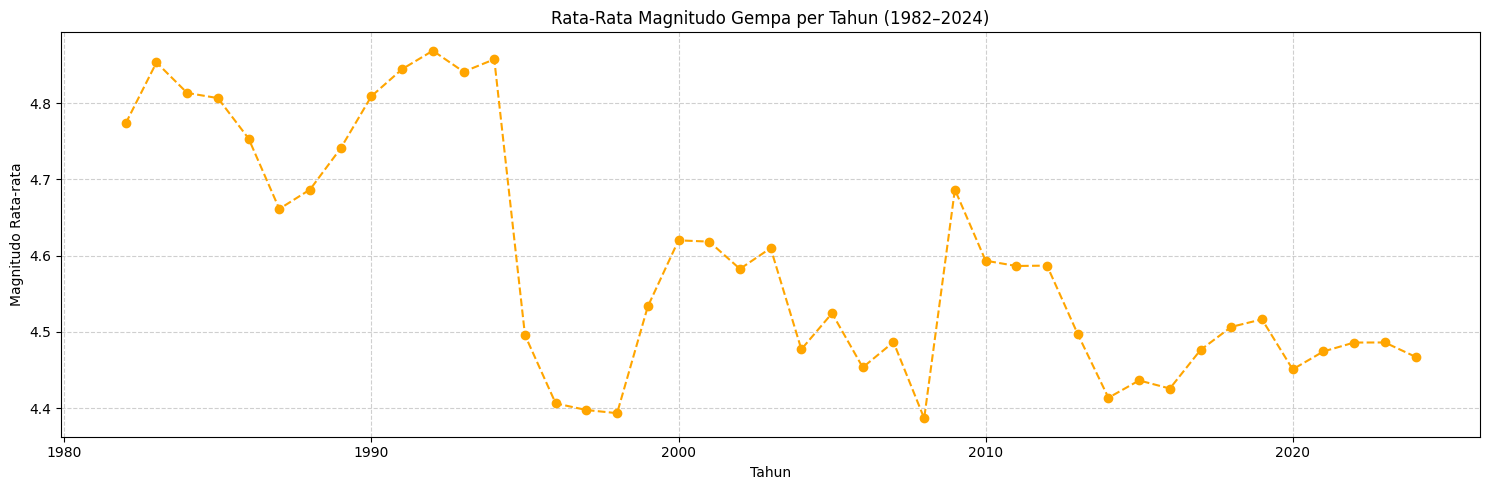

In [6]:
#2. Trend Rata-Rata Magnitudo

avg_mag = df.groupby('year')['mag'].mean().sort_index()

plt.figure(figsize=(15, 5))
plt.plot(avg_mag.index, avg_mag.values, marker='o', color='orange', linestyle='--')
plt.title('Rata-Rata Magnitudo Gempa per Tahun (1982–2024)')
plt.xlabel('Tahun')
plt.ylabel('Magnitudo Rata-rata')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



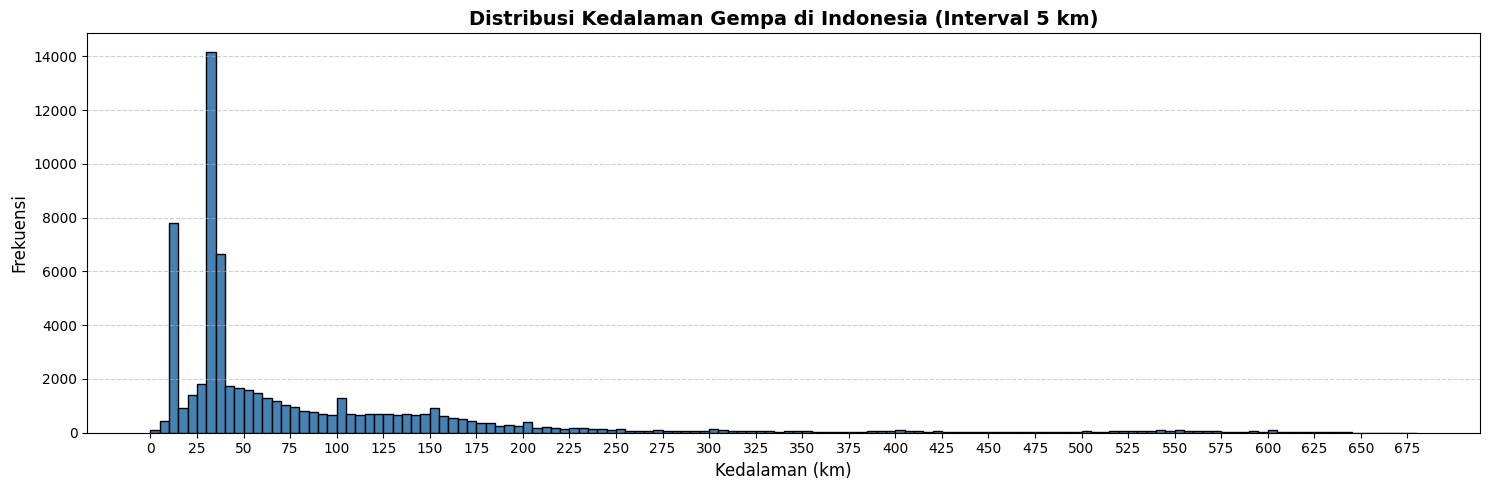

In [7]:

#3. Distribusi Kedalaman

# plt.figure(figsize=(15, 5))
# df['depth'].hist(bins=50)
# plt.title('Distribusi Kedalaman Gempa di Indonesia')
# plt.xlabel('Kedalaman (km)')
# plt.ylabel('Frekuensi')
# plt.show()


# Atur bin per 5 km dari 0 hingga kedalaman maksimum (misal 700 km)
bin_width = 5
max_depth = int(df['depth'].max()) + bin_width
bins = np.arange(0, max_depth + bin_width, bin_width)

# Plot histogram kedalaman
plt.figure(figsize=(15, 5))
plt.hist(df['depth'], bins=bins, color='steelblue', edgecolor='black')

# Judul dan label
plt.title('Distribusi Kedalaman Gempa di Indonesia (Interval 5 km)', fontsize=14, fontweight='bold')
plt.xlabel('Kedalaman (km)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)

# Atur grid dan tampilan
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(np.arange(0, max_depth + 1, 25))  # tampilkan label setiap 25 km
plt.tight_layout()
plt.show()



# import plotly.express as px

# # Buat bin per 5 km
# df['depth_bin'] = (df['depth'] // 5) * 5  # membulatkan ke bawah kelipatan 5

# fig = px.histogram(
#     df,
#     x='depth_bin',
#     nbins=int(df['depth'].max() // 5),
#     title='Distribusi Interaktif Kedalaman Gempa (Interval 5 km)',
#     labels={'depth_bin': 'Kedalaman (km)', 'count': 'Frekuensi'},
#     color_discrete_sequence=['steelblue']
# )

# fig.update_layout(
#     xaxis_title='Kedalaman (km)',
#     yaxis_title='Frekuensi',
#     bargap=0.05,
#     template='plotly_white'
# )

# fig.show()


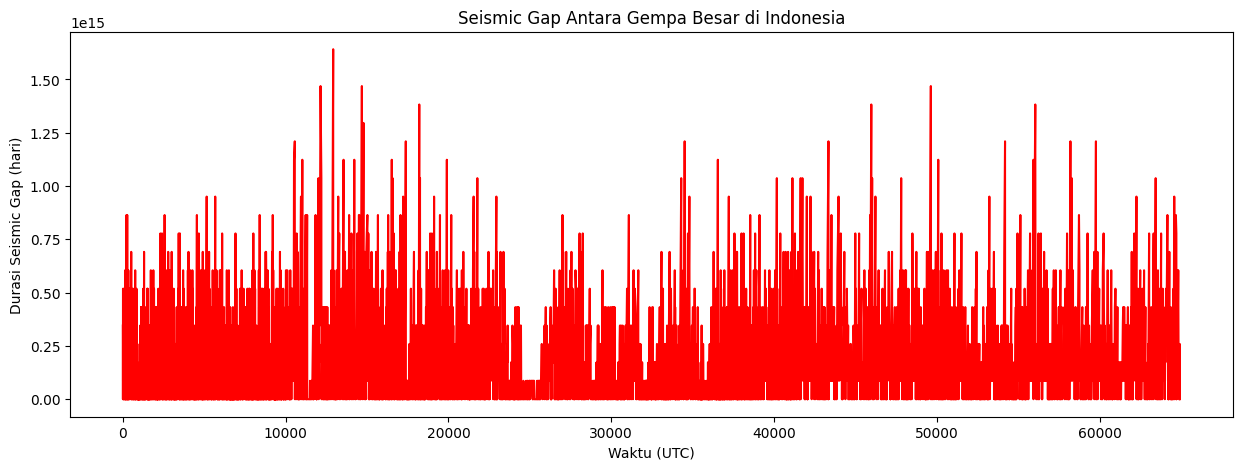

In [8]:
#4. Seismic Gap Temporal

# Contoh: Analisis waktu antar gempa besar
large_magnitude = df[df['mag'] >= 5]
times = pd.to_datetime(large_magnitude['date'])
times_diff = pd.Series(times).diff().dropna()
plt.figure(figsize=(15, 5))
plt.plot(times_diff, 'r')
plt.title('Seismic Gap Antara Gempa Besar di Indonesia')
plt.xlabel('Waktu (UTC)')
plt.ylabel('Durasi Seismic Gap (hari)')
plt.show()


c. Distribusi Statis

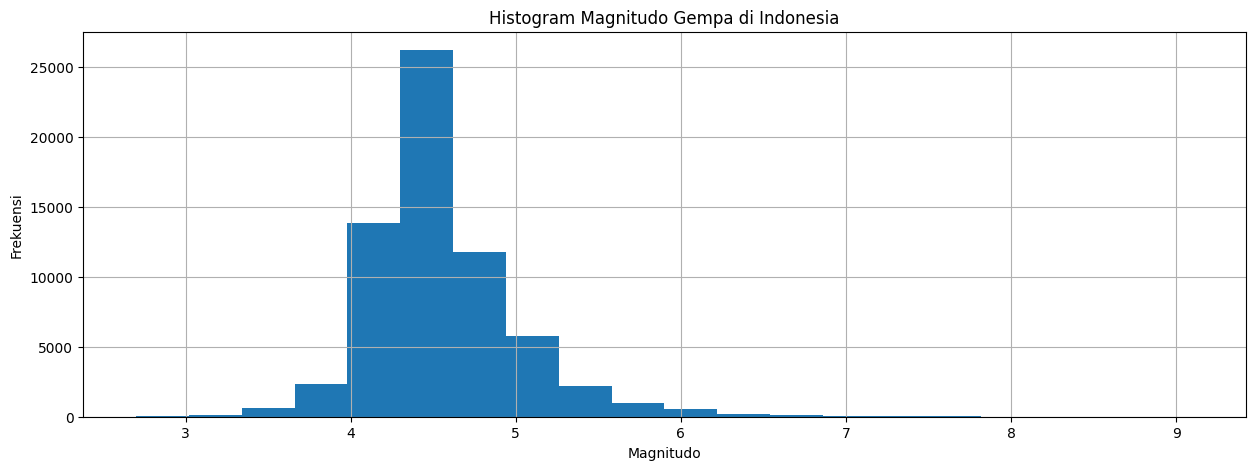

In [9]:
#1. Histogram Magnitudo

plt.figure(figsize=(15, 5))
df['mag'].hist(bins=20)
plt.title('Histogram Magnitudo Gempa di Indonesia')
plt.xlabel('Magnitudo')
plt.ylabel('Frekuensi')
plt.show()


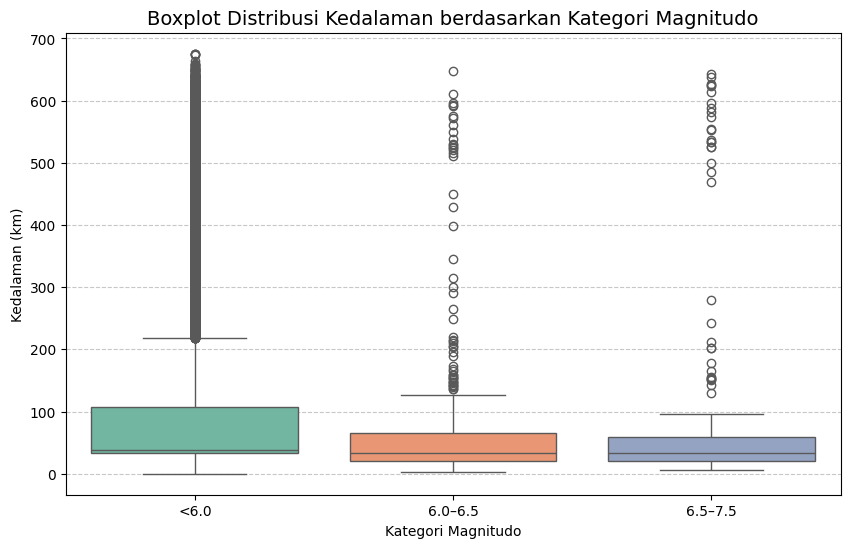

In [10]:
#2. Boxplot Kedalaman

import seaborn as sns
# Buat kategori magnitudo
bins = [0, 6.0, 6.5, 7.5]
labels = ['<6.0', '6.0–6.5', '6.5–7.5']
df['mag_category'] = pd.cut(df['mag'], bins=bins, labels=labels)

# Plot boxplot dengan seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='mag_category', y='depth', data=df, palette='Set2')

plt.title('Boxplot Distribusi Kedalaman berdasarkan Kategori Magnitudo', fontsize=14)
plt.xlabel('Kategori Magnitudo')
plt.ylabel('Kedalaman (km)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


In [11]:
#3. Statistik Deskriptif

stats = df.describe()
print(stats)


           latitude     longitude         depth           mag           rms  \
count  64947.000000  64947.000000  64947.000000  64947.000000  64947.000000   
mean      -2.336929    121.485402     85.464222      4.539186      0.922949   
std        4.456350     12.212526    105.826012      0.459961      0.282739   
min       -9.999000     95.000000      0.000000      2.700000      0.000000   
25%       -6.608000    116.596200     33.000000      4.200000      0.720000   
50%       -2.526000    126.345000     37.700000      4.500000      0.920000   
75%        1.537350    128.933950    106.800000      4.800000      1.110000   
max        5.999800    140.999000    675.500000      9.100000      1.940000   

               year         month           day       lat_bin       lon_bin  \
count  64947.000000  64947.000000  64947.000000  64947.000000  64947.000000   
mean    2006.953177      6.474063     15.793909     -2.589581    121.234653   
std       11.148909      3.485268      8.721572    

D. Binning Lokasi: Spatial Grid


In [12]:
#Urutkan data secara kronologis berdasarkan waktu kejadian

df = df.set_index('date').sort_index().reset_index(drop=True)


In [13]:
#1. Tentukan ukuran grid spasial (default: 0.5° x 0.5°)'

def haversine(lat1, lon1, lat2, lon2):
    # Konversi derajat ke radian
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius bumi dalam kilometer
    return c * r


In [14]:
#2. Tambahkan kolom lat_bin dan lon_bin


# Definisikan grid size
grid_size = 0.5  # untuk grid 0.5° x 0.5°

# Bikin bin edges untuk latitude dan longitude
lat_bins = np.arange(-90, 90 + grid_size, grid_size)
lon_bins = np.arange(-180, 180 + grid_size, grid_size)

# Terapkan pd.cut untuk bikin kolom bin baru
df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=lat_bins[:-1])
df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=lon_bins[:-1])


In [15]:
#3. Tampilkan ringkasan jumlah data

print(f"Total data: {df.shape[0]}")
print(f"Missing values in latitude/longitude: {df[(df['latitude'].isnull()) | (df['longitude'].isnull())].shape[0]}")
print("Number of duplicates:", df.duplicated().sum())


Total data: 64947
Missing values in latitude/longitude: 0
Number of duplicates: 0


E. Visualisasi Temporal

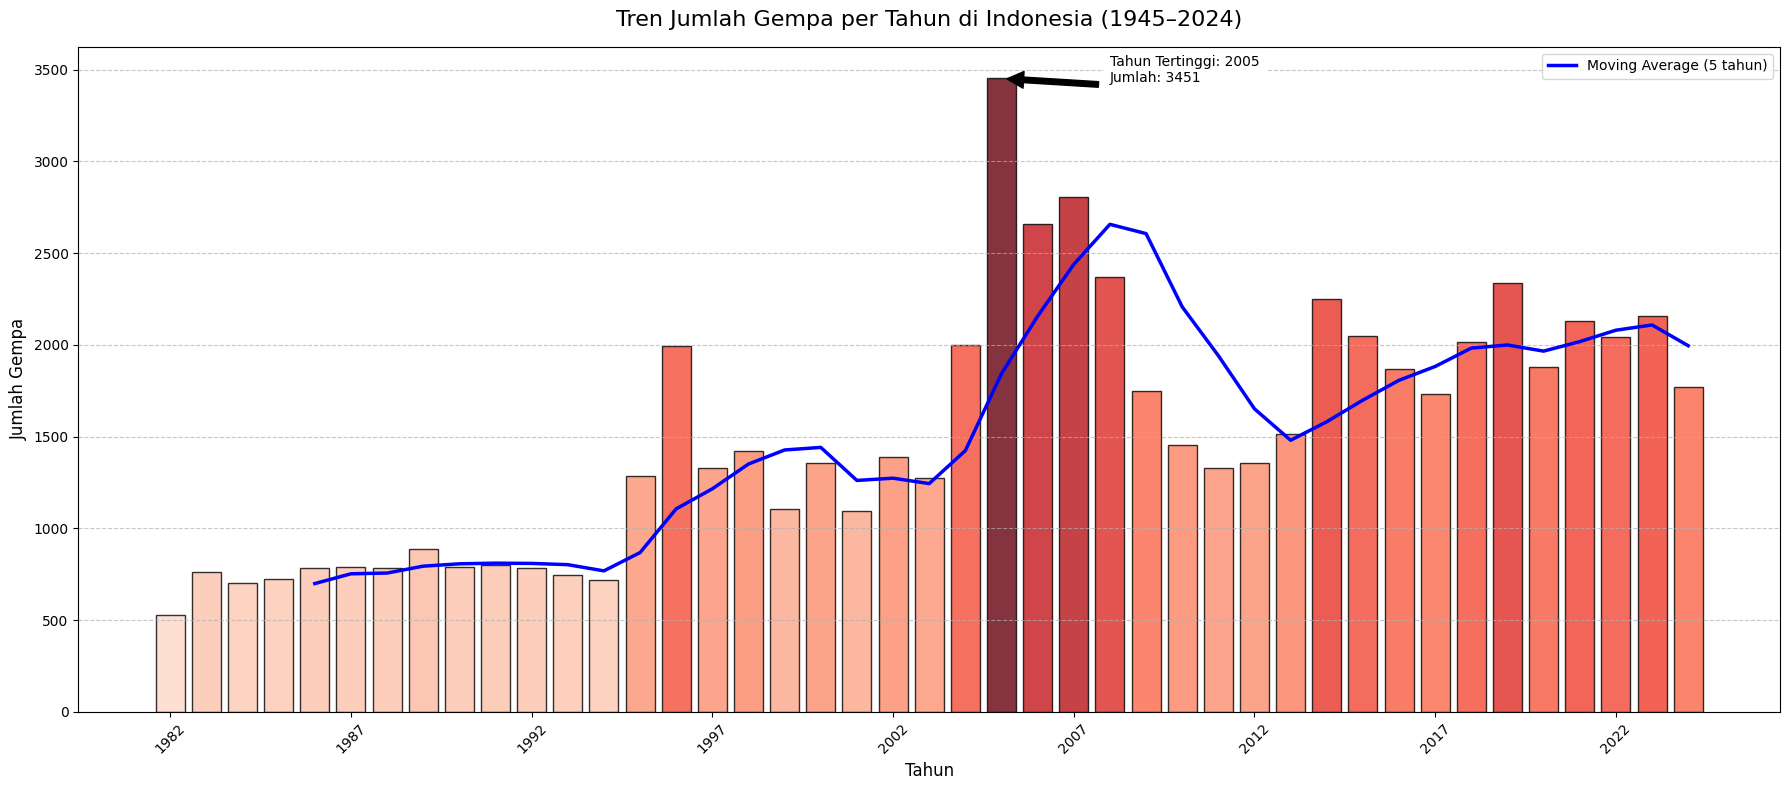

In [16]:
#1. Plot jumlah gempa per tahun

# Step 1: Pastikan kolom 'year' aman
# Kalau sebelumnya kolom 'year' pecahan dari 'date', pastikan di-generate dulu
if 'year' not in df.columns:
    df['year'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce').dt.year

# Step 2: Hapus NaN di kolom 'year' sebelum konversi
df_clean = df.dropna(subset=['year'])

# Step 3: Convert dengan aman
df_clean['year'] = df_clean['year'].astype(int)

# Step 4: Grouping jumlah gempa per tahun
gempa_per_tahun = df_clean.groupby('year')['mag'].count()

# Step 5: Moving average
moving_avg = gempa_per_tahun.rolling(window=5).mean()

# Step 6: Plotting
plt.figure(figsize=(18, 8))

# Bar plot dengan warna gradien
bars = plt.bar(gempa_per_tahun.index, gempa_per_tahun.values, 
               color=plt.cm.Reds(gempa_per_tahun.values / max(gempa_per_tahun.values)),
               edgecolor='black', alpha=0.8)

# Garis moving average
plt.plot(gempa_per_tahun.index, moving_avg, color='blue', linewidth=2.5, label='Moving Average (5 tahun)')

# Anotasi tahun puncak
peak_year = gempa_per_tahun.idxmax()
peak_value = gempa_per_tahun.max()
plt.annotate(f'Tahun Tertinggi: {peak_year}\nJumlah: {peak_value}', 
             xy=(peak_year, peak_value), 
             xytext=(peak_year + 3, peak_value - 20),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, backgroundcolor='white')

# Judul dan label
plt.title("Tren Jumlah Gempa per Tahun di Indonesia (1945–2024)", fontsize=16, pad=15)
plt.xlabel("Tahun", fontsize=12)
plt.ylabel("Jumlah Gempa", fontsize=12)

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# X-ticks setiap 5 tahun
plt.xticks(range(df_clean['year'].min(), df_clean['year'].max() + 1, 5), rotation=45)

# Legend
plt.legend()

# Layout rapih
plt.tight_layout()

plt.show()

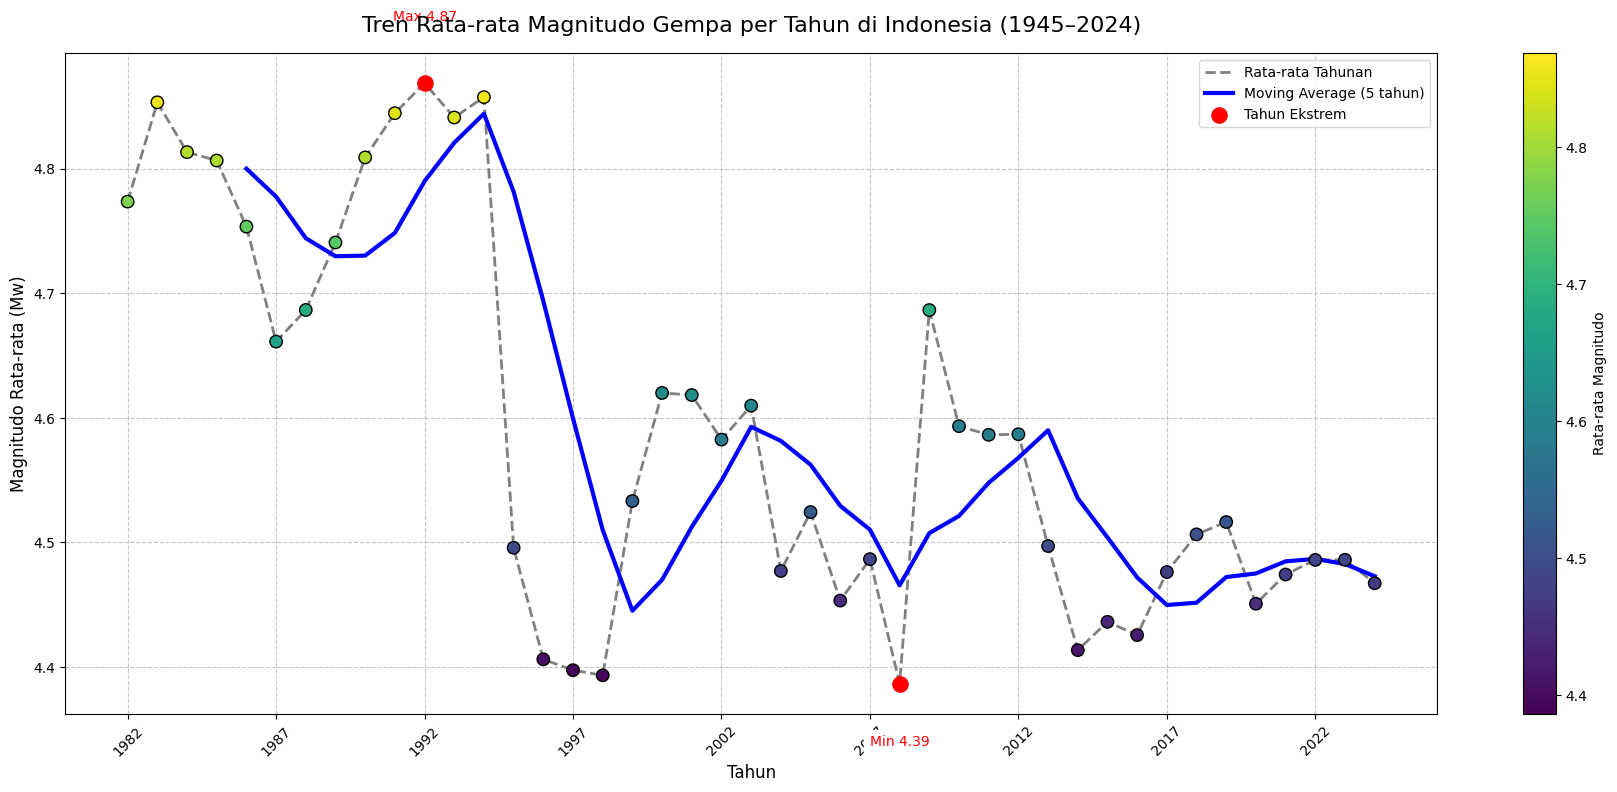

In [17]:
#2. Plot tren rata-rata magnitudo per tahun

# Step 1: Pastikan kolom 'year' aman
if 'year' not in df.columns:
    df['year'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce').dt.year

# Step 2: Hapus NaN di kolom 'year' dan 'mag'
df_clean = df.dropna(subset=['year', 'mag'])

# Step 3: Konversi 'year' ke integer
df_clean['year'] = df_clean['year'].astype(int)

# Step 4: Group by rata-rata magnitudo
mean_magnitude = df_clean.groupby('year')['mag'].mean()

# Step 5: Moving average (opsional, biar lebih smooth trennya)
moving_avg = mean_magnitude.rolling(window=5).mean()

# Step 6: Plotting
plt.figure(figsize=(18, 8))

# Warna gradasi berdasarkan nilai rata-rata
points = plt.scatter(mean_magnitude.index, mean_magnitude.values, 
                     c=mean_magnitude.values, cmap='viridis', s=80, edgecolor='black', zorder=3)

# Garis tren
plt.plot(mean_magnitude.index, mean_magnitude.values, color='gray', linestyle='--', linewidth=2, label='Rata-rata Tahunan')

# Moving average
plt.plot(moving_avg.index, moving_avg.values, color='blue', linewidth=3, label='Moving Average (5 tahun)')

# Highlight tahun minimum & maksimum
min_year = mean_magnitude.idxmin()
max_year = mean_magnitude.idxmax()
plt.scatter([min_year, max_year], [mean_magnitude[min_year], mean_magnitude[max_year]], 
            color='red', s=120, zorder=5, label='Tahun Ekstrem')
plt.text(min_year, mean_magnitude[min_year] - 0.05, f'Min {mean_magnitude[min_year]:.2f}', 
         ha='center', color='red', fontsize=10, backgroundcolor='white')
plt.text(max_year, mean_magnitude[max_year] + 0.05, f'Max {mean_magnitude[max_year]:.2f}', 
         ha='center', color='red', fontsize=10, backgroundcolor='white')

# Colorbar untuk gradasi
cbar = plt.colorbar(points)
cbar.set_label('Rata-rata Magnitudo')

# Judul dan label
plt.title("Tren Rata-rata Magnitudo Gempa per Tahun di Indonesia (1945–2024)", fontsize=16, pad=15)
plt.xlabel("Tahun", fontsize=12)
plt.ylabel("Magnitudo Rata-rata (Mw)", fontsize=12)

# Grid
plt.grid(axis='both', linestyle='--', alpha=0.7)

# X-ticks setiap 5 tahun
plt.xticks(range(df_clean['year'].min(), df_clean['year'].max() + 1, 5), rotation=45)

# Legend
plt.legend()

# Layout rapih
plt.tight_layout()

plt.show()


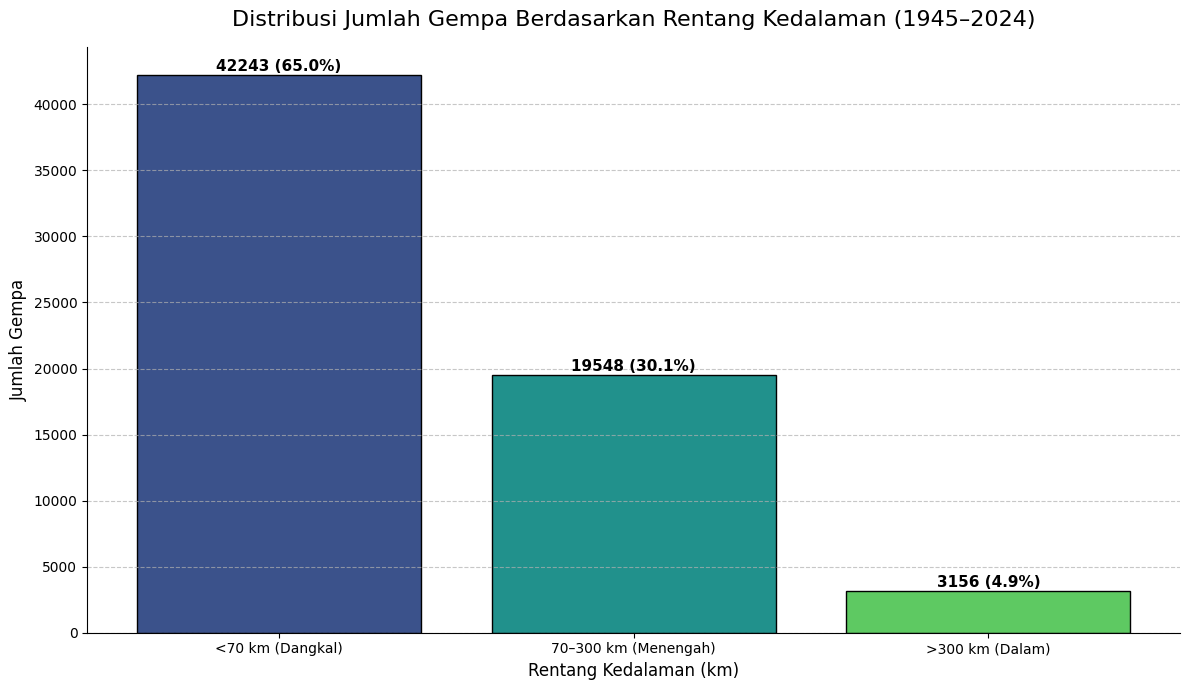

In [18]:
#3. Plot jumlah gempa berdasarkan rentang kedalaman

# Step 1: Cek data depth, pastikan tidak ada NaN
df_clean = df.dropna(subset=['depth'])

# Step 2: Binning depth (kedalaman)
depth_bins = [0, 70, 300, df_clean['depth'].max()]
depth_labels = ['<70 km (Dangkal)', '70–300 km (Menengah)', '>300 km (Dalam)']

df_clean['depth_category'] = pd.cut(df_clean['depth'], bins=depth_bins, labels=depth_labels, include_lowest=True)

# Step 3: Hitung jumlah gempa per kategori kedalaman
counts = df_clean['depth_category'].value_counts().sort_index()

# Step 4: Hitung persentase tiap kategori
percentages = (counts / counts.sum()) * 100

# Step 5: Plotting
plt.figure(figsize=(12, 7))
colors = sns.color_palette('viridis', len(counts))

bars = plt.bar(counts.index, counts.values, color=colors, edgecolor='black')

# Tambahkan label jumlah di atas bar
for bar, count, pct in zip(bars, counts.values, percentages.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50, 
             f'{count} ({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Judul dan label sumbu
plt.title('Distribusi Jumlah Gempa Berdasarkan Rentang Kedalaman (1945–2024)', fontsize=16, pad=15)
plt.xlabel('Rentang Kedalaman (km)', fontsize=12)
plt.ylabel('Jumlah Gempa', fontsize=12)

# Grid horizontal untuk memperjelas
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hapus spines yang tidak perlu
sns.despine()

# Layout rapih
plt.tight_layout()

plt.show()


In [19]:
print(df.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'magType', 'rms', 'net', 'id',
       'updated', 'place', 'type', 'status', 'magSource', 'year', 'month',
       'day', 'mag_category', 'lat_bin', 'lon_bin', 'dekade'],
      dtype='object')


Index(['latitude', 'longitude', 'depth', 'mag', 'magType', 'rms', 'net', 'id',
       'updated', 'place', 'type', 'status', 'magSource', 'year', 'month',
       'day', 'mag_category', 'lat_bin', 'lon_bin', 'dekade'],
      dtype='object')


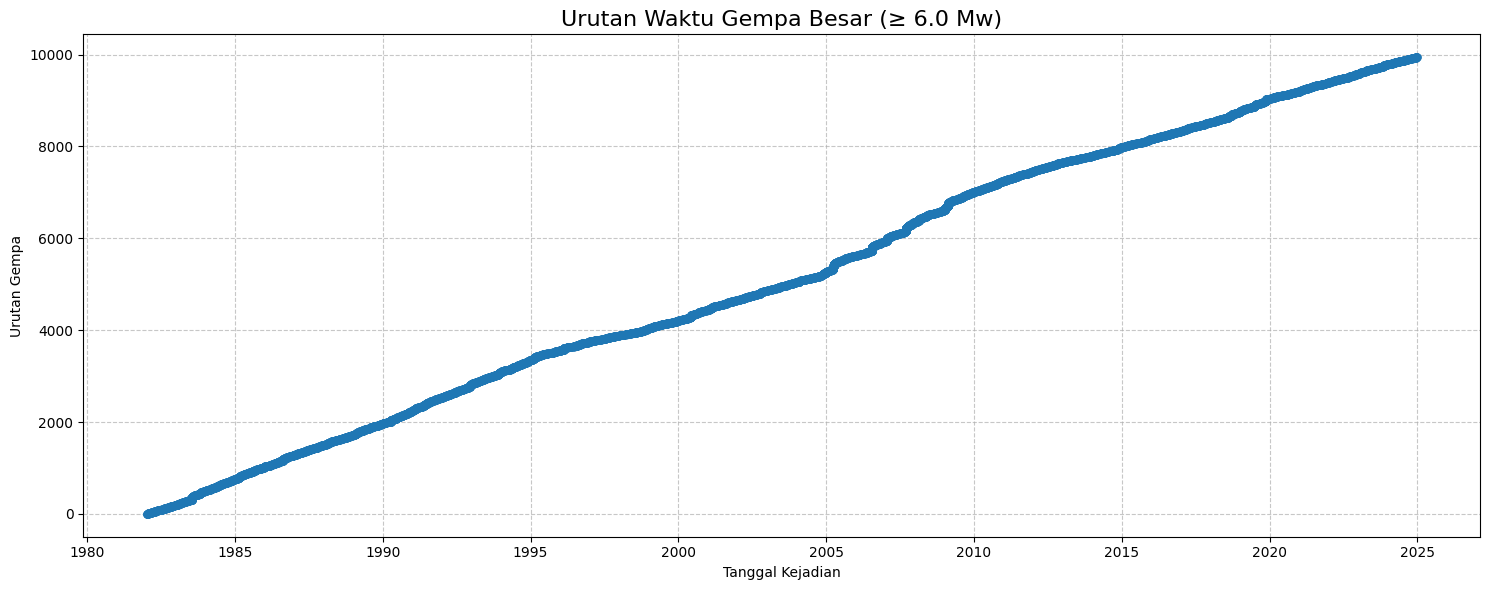

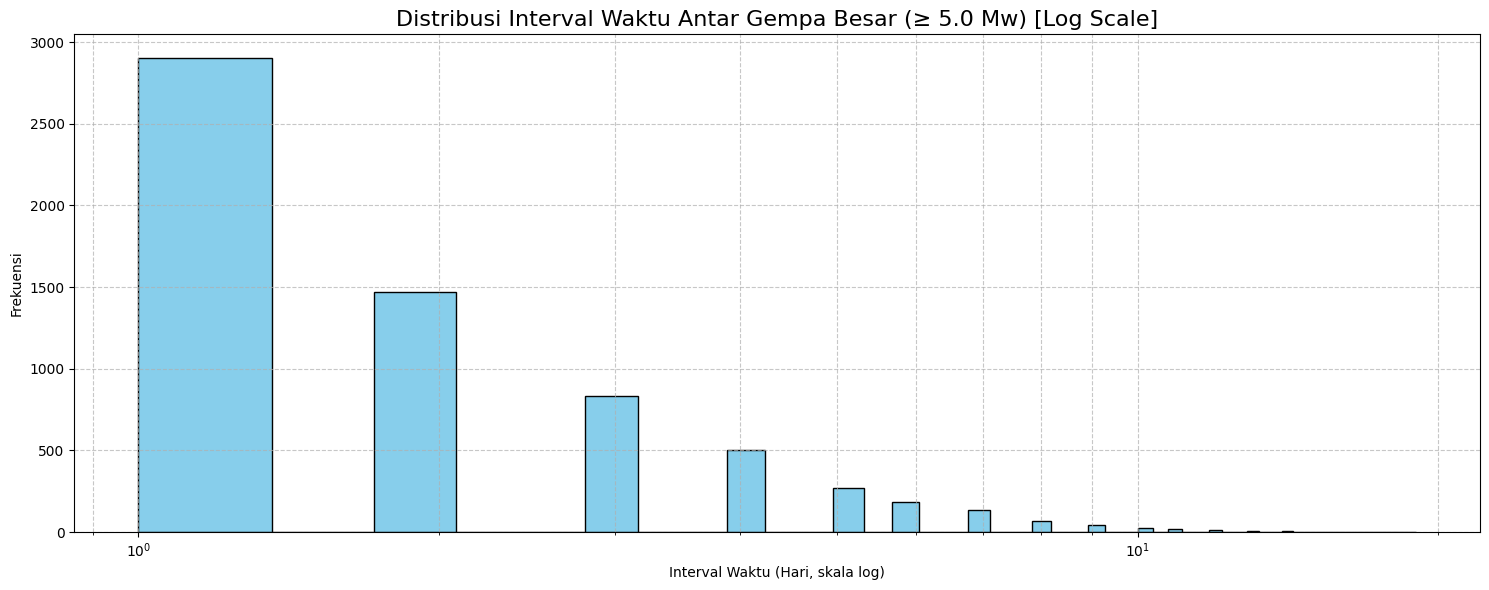

In [20]:
#4. Analisis distribusi waktu antar gempa besar (≥4.0)


# Step 1: Cek kolom waktu yang tersedia
print(df.columns)

# Step 2: Filter gempa dengan magnitudo ≥ 6.0
gempas = df[df['mag'] >= 5].copy()

# Step 3: Buat kolom datetime, pastikan kolom 'year', 'month', 'day' tidak ada NaN
# Jika ada NaN, drop sementara untuk visualisasi
gempas = gempas.dropna(subset=['year', 'month', 'day'])
gempas['datetime'] = pd.to_datetime(dict(year=gempas['year'].astype(int),
                                         month=gempas['month'].astype(int),
                                         day=gempas['day'].astype(int)),
                                    errors='coerce')

# Drop yang gagal konversi datetime
gempas = gempas.dropna(subset=['datetime'])

# Step 4: Hitung interval waktu antar gempa
gempas = gempas.sort_values('datetime')
gempas['interval_days'] = gempas['datetime'].diff().dt.days.fillna(0)

# Step 5: Plot urutan waktu kejadian
plt.figure(figsize=(15, 6))
plt.plot(gempas['datetime'], np.arange(len(gempas)), 'o-', markersize=5, linewidth=1)
plt.title("Urutan Waktu Gempa Besar (≥ 6.0 Mw)", fontsize=16)
plt.xlabel("Tanggal Kejadian")
plt.ylabel("Urutan Gempa")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 6: Plot distribusi interval antar gempa (dengan filter > 0 hari)
intervals = gempas['interval_days']
intervals = intervals[intervals > 0]  # Hilangkan nilai 0 agar tidak error di log scale

plt.figure(figsize=(15, 6))
plt.hist(intervals, bins=50, color='skyblue', edgecolor='black')
plt.xscale('log')
plt.title("Distribusi Interval Waktu Antar Gempa Besar (≥ 5.0 Mw) [Log Scale]", fontsize=16)
plt.xlabel("Interval Waktu (Hari, skala log)")
plt.ylabel("Frekuensi")
plt.grid(True, linestyle='--', alpha=0.7, which='both')
plt.tight_layout()
plt.show()



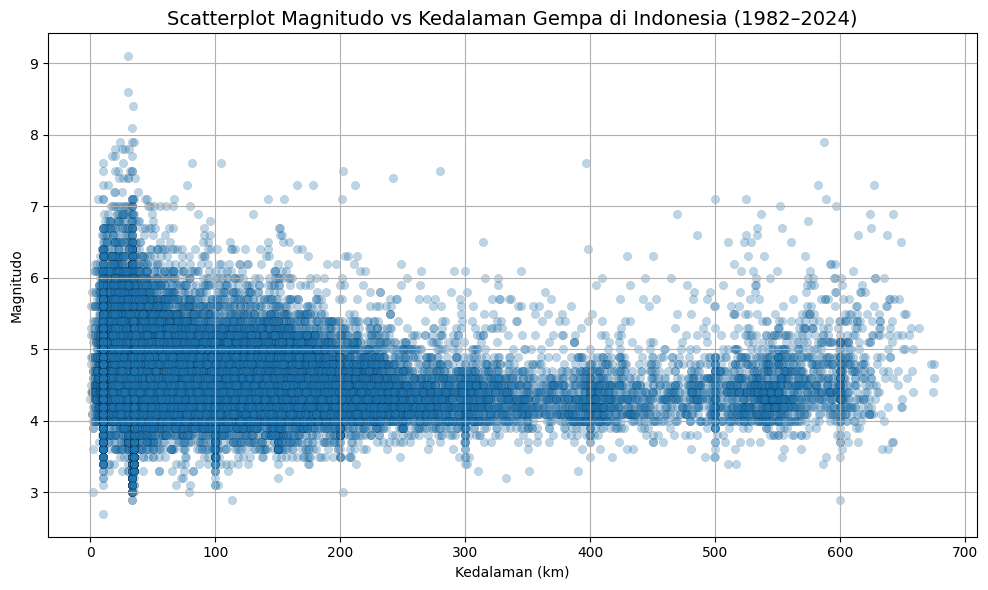

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(df['depth'], df['mag'], alpha=0.3, edgecolor='k', linewidths=0.2)
plt.title('Scatterplot Magnitudo vs Kedalaman Gempa di Indonesia (1982–2024)', fontsize=14)
plt.xlabel('Kedalaman (km)')
plt.ylabel('Magnitudo')
plt.grid(True)
plt.tight_layout()
plt.show()


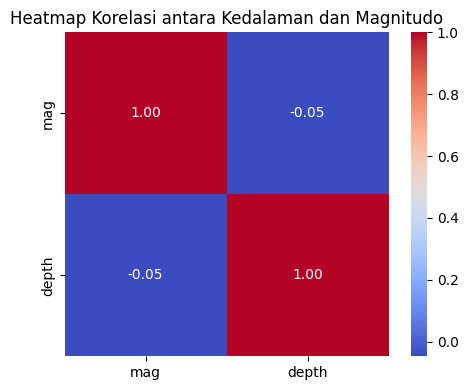

In [33]:


# Korelasi antar fitur numerik (bisa tambah fitur lain juga jika ada)
corr = df[['mag', 'depth']].corr(method='pearson')

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Heatmap Korelasi antara Kedalaman dan Magnitudo')
plt.tight_layout()
plt.show()


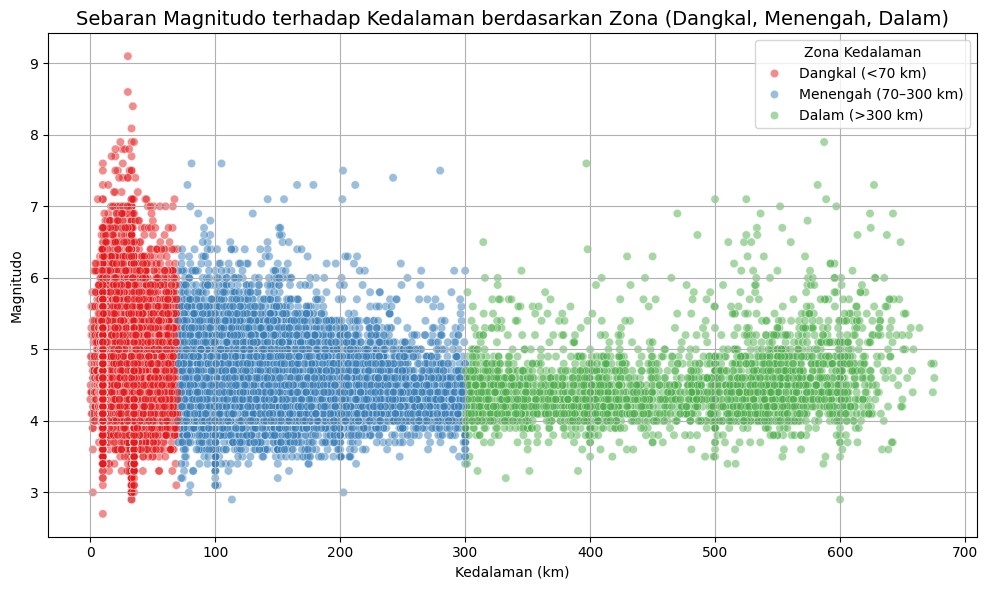

In [32]:
# Tambah kolom zona kedalaman
def depth_zone(depth):
    if depth < 70:
        return 'Dangkal (<70 km)'
    elif depth <= 300:
        return 'Menengah (70–300 km)'
    else:
        return 'Dalam (>300 km)'

df['depth_zone'] = df['depth'].apply(depth_zone)

# Scatterplot dengan warna berdasarkan zona
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='depth', y='mag', hue='depth_zone', palette='Set1', alpha=0.5)
plt.title('Sebaran Magnitudo terhadap Kedalaman berdasarkan Zona (Dangkal, Menengah, Dalam)', fontsize=14)
plt.xlabel('Kedalaman (km)')
plt.ylabel('Magnitudo')
plt.legend(title='Zona Kedalaman')
plt.grid(True)
plt.tight_layout()
plt.show()


F. Visualisasi Spasial

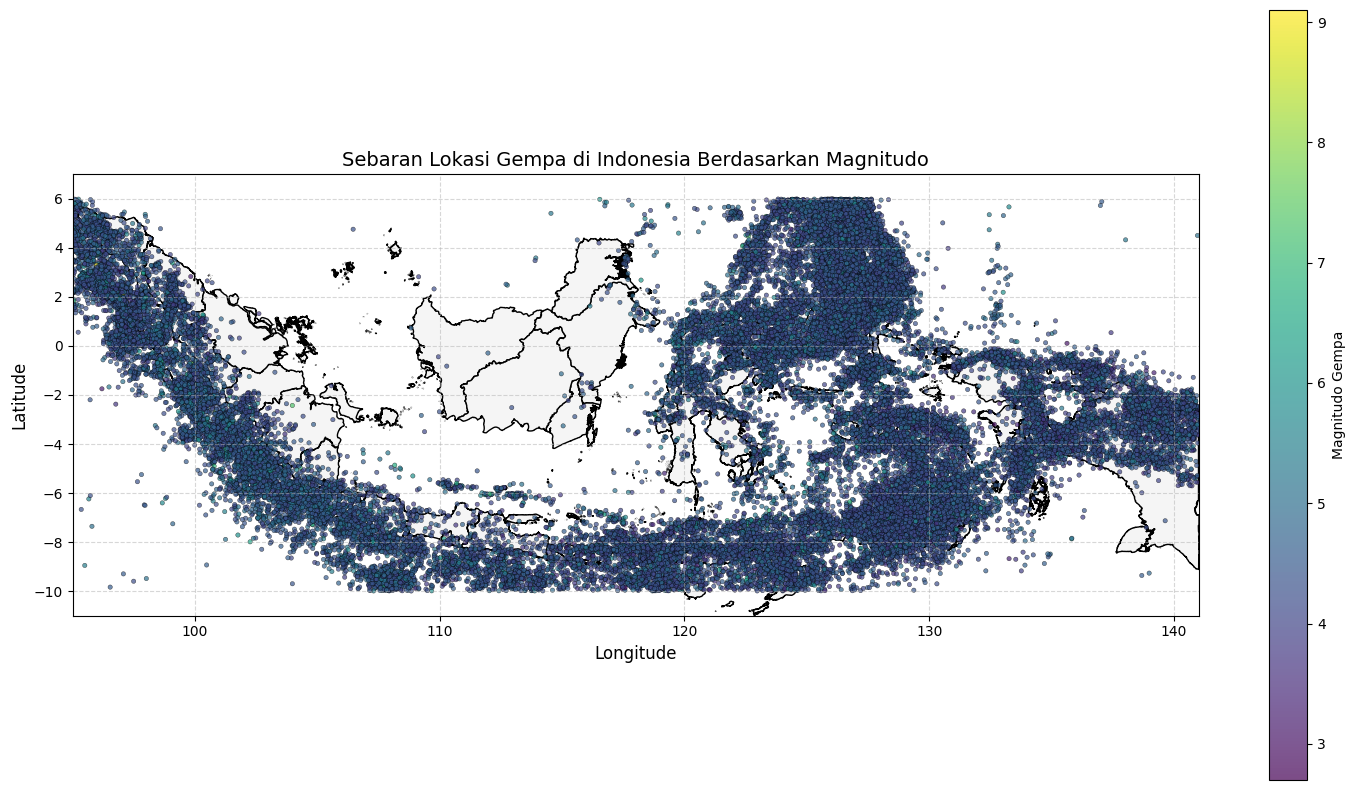

In [23]:
#1. Scatter plot lokasi gempa

import geopandas as gpd
import matplotlib.pyplot as plt

# Load shapefile GADM Indonesia
gdf = gpd.read_file("gadm41_IDN_shp/gadm41_IDN_1.shp")  # <= ganti dengan path kamu

# Plot peta dasar Indonesia
fig, ax = plt.subplots(figsize=(15, 8))
gdf.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Scatter plot lokasi gempa
scatter = ax.scatter(
    df['longitude'], df['latitude'],
    s=10,
    c=df['mag'],
    cmap='viridis',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.3
)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Magnitudo Gempa')

# Judul dan label axis
ax.set_title("Sebaran Lokasi Gempa di Indonesia Berdasarkan Magnitudo", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Fokuskan ke wilayah Indonesia
ax.set_xlim(95, 141)
ax.set_ylim(-11, 7)

# Grid
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
  




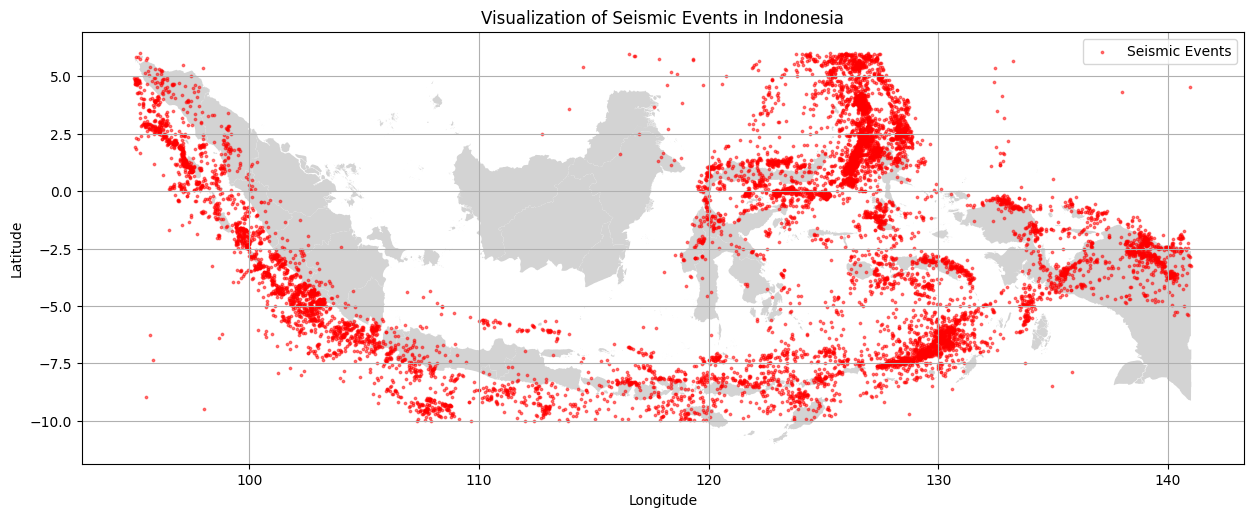

In [24]:
gempas['geometry'] = [Point(xy) for xy in zip(gempas['longitude'], gempas['latitude'])]
gdf = gpd.GeoDataFrame(gempas, geometry='geometry')

# Tetapkan CRS (Coordinate Reference System)
gdf.set_crs(epsg=4326, inplace=True)

# Path ke shapefile Indonesia
indonesia_shapefile_path = 'gadm41_IDN_shp/gadm41_IDN_1.shp'  # Sesuaikan path

# Muat shapefile
indonesia_map = gpd.read_file(indonesia_shapefile_path)

# Plot peta dan data seismik
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))
indonesia_map.plot(ax=ax, color='lightgray')
gdf.plot(ax=ax, marker='o', color='red', markersize=3, alpha=0.5, label='Seismic Events')  # Mengurangi ukuran dan menambah transparansi
plt.legend()
plt.title('Visualization of Seismic Events in Indonesia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)  # Menambahkan grid untuk navigasi yang lebih mudah
plt.show()


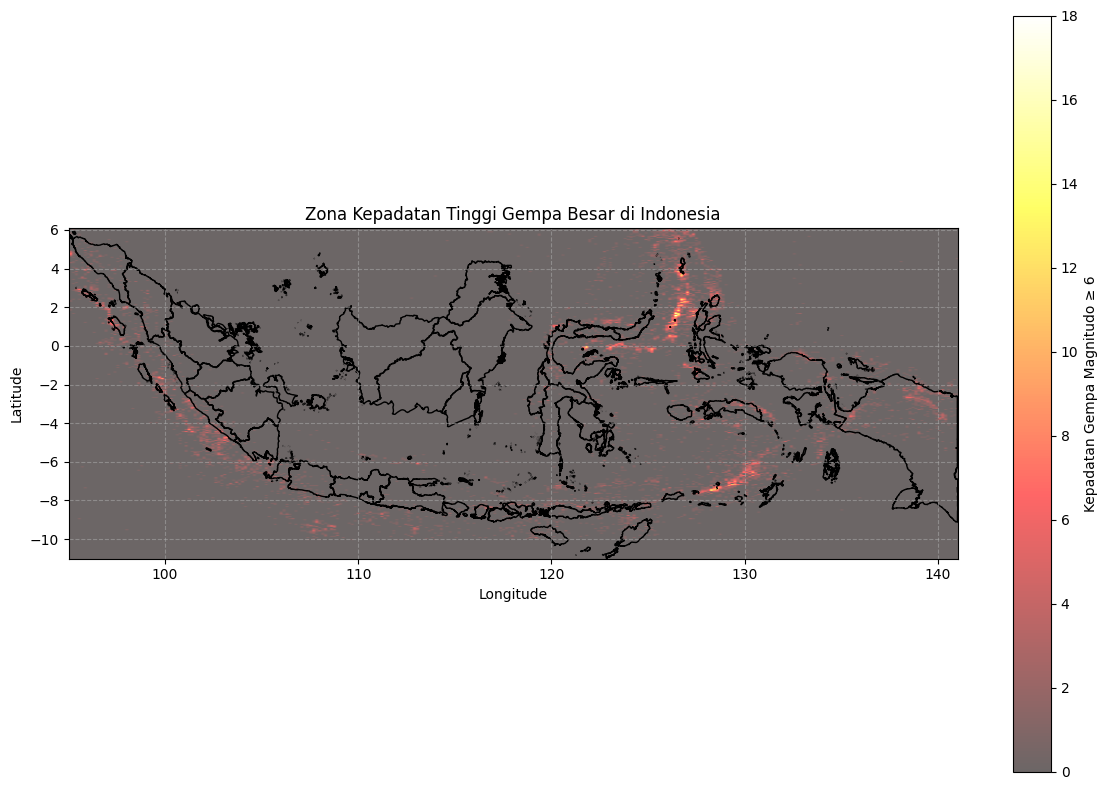

In [25]:
#4. Tandai zona dengan kepadatan tinggi

# Load shapefile Indonesia (ganti path ke path shapefile kamu)
shapefile_path = "gadm41_IDN_shp/gadm41_IDN_1.shp"
indonesia = gpd.read_file(shapefile_path)

# Bikin grid untuk heatmap
x = gempas['longitude']
y = gempas['latitude']

# Ambil bounding box dari shapefile untuk extent heatmap
minx, miny, maxx, maxy = indonesia.total_bounds

# Buat histogram 2D untuk menghitung kepadatan
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(300, 300), range=[[minx, maxx], [miny, maxy]])

# Plot peta dan heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Plot peta Indonesia
indonesia.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot heatmap dengan extent sesuai peta
im = ax.imshow(
    heatmap.T,
    extent=[minx, maxx, miny, maxy],
    origin='lower',
    cmap='hot',
    alpha=0.6
)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Kepadatan Gempa Magnitudo ≥ 6')

# Pengaturan tambahan
ax.set_title('Zona Kepadatan Tinggi Gempa Besar di Indonesia')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

G. Distribusi Statis

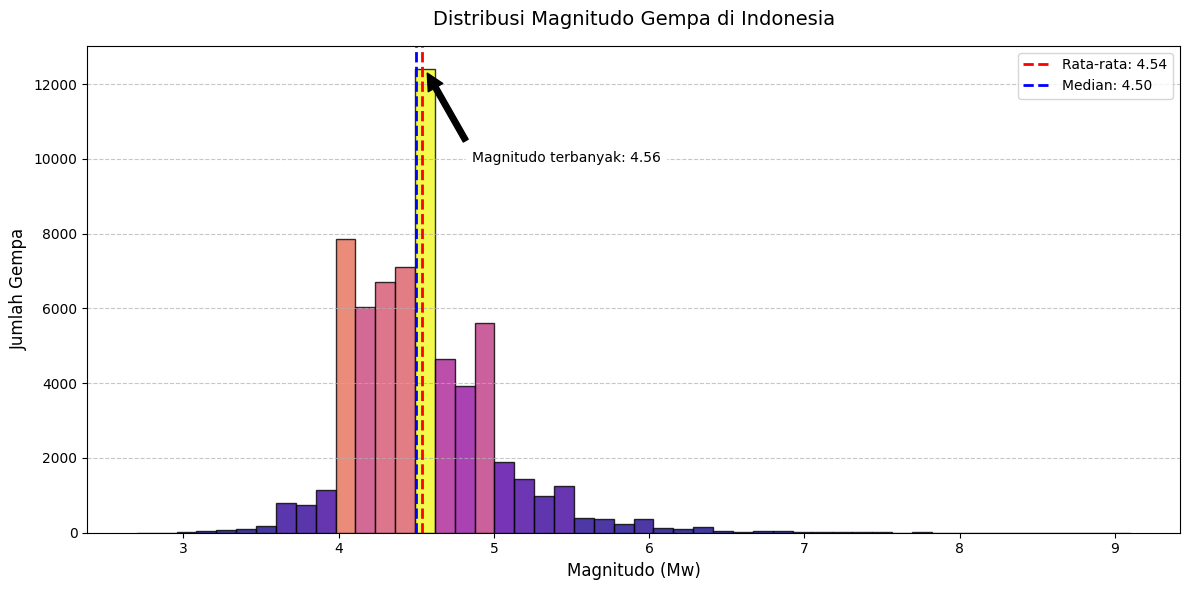

In [26]:
#1. Histogram distribusi magnitudo

plt.figure(figsize=(12, 6))

# Data
magnitudes = df['mag']
bins = 50

# Buat histogram
counts, bin_edges, patches = plt.hist(magnitudes, bins=bins, edgecolor='black', alpha=0.8)

# Gradasi warna berdasarkan frekuensi
norm = plt.Normalize(counts.min(), counts.max())
for c, p in zip(counts, patches):
    plt.setp(p, 'facecolor', plt.cm.plasma(norm(c)))

# Garis rata-rata dan median
mean_mag = magnitudes.mean()
median_mag = magnitudes.median()

plt.axvline(mean_mag, color='red', linestyle='--', linewidth=2, label=f'Rata-rata: {mean_mag:.2f}')
plt.axvline(median_mag, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_mag:.2f}')

# Anotasi magnitudo paling sering terjadi
max_count_index = np.argmax(counts)
most_common_mag = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2
plt.annotate(
    f'Magnitudo terbanyak: {most_common_mag:.2f}',
    xy=(most_common_mag, counts[max_count_index]),
    xytext=(most_common_mag + 0.3, counts.max() * 0.8),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=10,
    backgroundcolor='white'
)

# Judul dan label
plt.title("Distribusi Magnitudo Gempa di Indonesia", fontsize=14, pad=15)
plt.xlabel("Magnitudo (Mw)", fontsize=12)
plt.ylabel("Jumlah Gempa", fontsize=12)

# Grid halus
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
plt.legend()

# Layout rapi
plt.tight_layout()

plt.show()


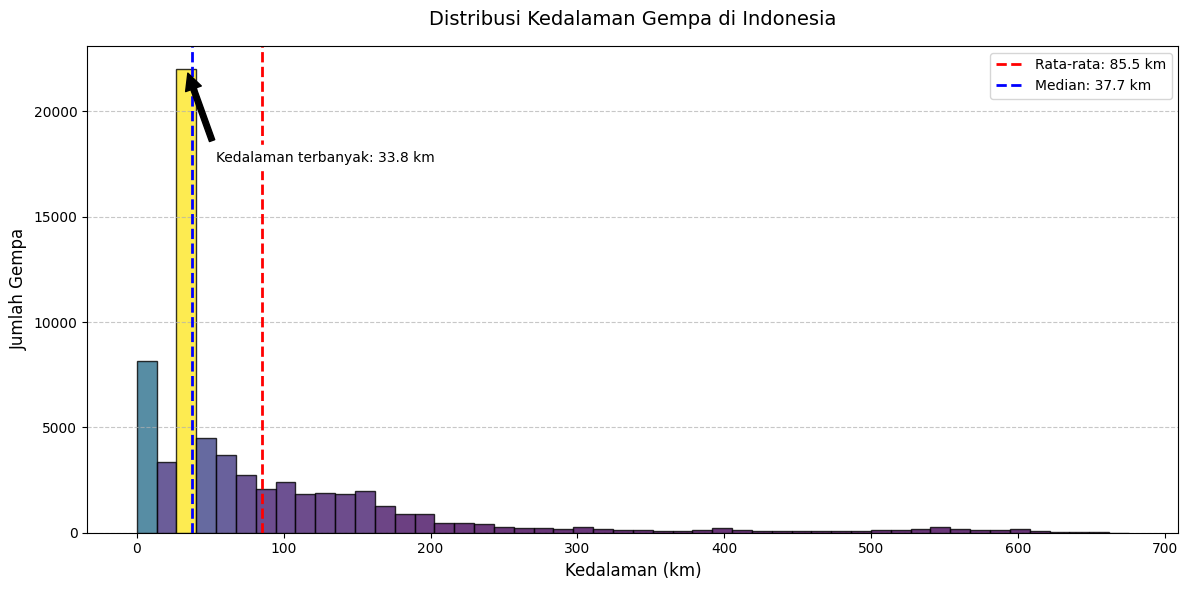

In [27]:
#2. Histogram distribusi kedalaman

plt.figure(figsize=(12, 6))

# Data
depths = df['depth']
bins = 50

# Buat histogram
counts, bin_edges, patches = plt.hist(depths, bins=bins, edgecolor='black', alpha=0.8)

# Gradasi warna berdasarkan frekuensi
norm = plt.Normalize(counts.min(), counts.max())
for c, p in zip(counts, patches):
    plt.setp(p, 'facecolor', plt.cm.viridis(norm(c)))

# Garis rata-rata dan median
mean_depth = depths.mean()
median_depth = depths.median()

plt.axvline(mean_depth, color='red', linestyle='--', linewidth=2, label=f'Rata-rata: {mean_depth:.1f} km')
plt.axvline(median_depth, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_depth:.1f} km')

# Anotasi depth paling sering terjadi
max_count_index = np.argmax(counts)
most_common_depth = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2
plt.annotate(
    f'Kedalaman terbanyak: {most_common_depth:.1f} km',
    xy=(most_common_depth, counts[max_count_index]),
    xytext=(most_common_depth + 20, counts.max() * 0.8),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=10,
    backgroundcolor='white'
)

# Judul dan label
plt.title("Distribusi Kedalaman Gempa di Indonesia", fontsize=14, pad=15)
plt.xlabel("Kedalaman (km)", fontsize=12)
plt.ylabel("Jumlah Gempa", fontsize=12)

# Grid horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
plt.legend()

plt.tight_layout()
plt.show()

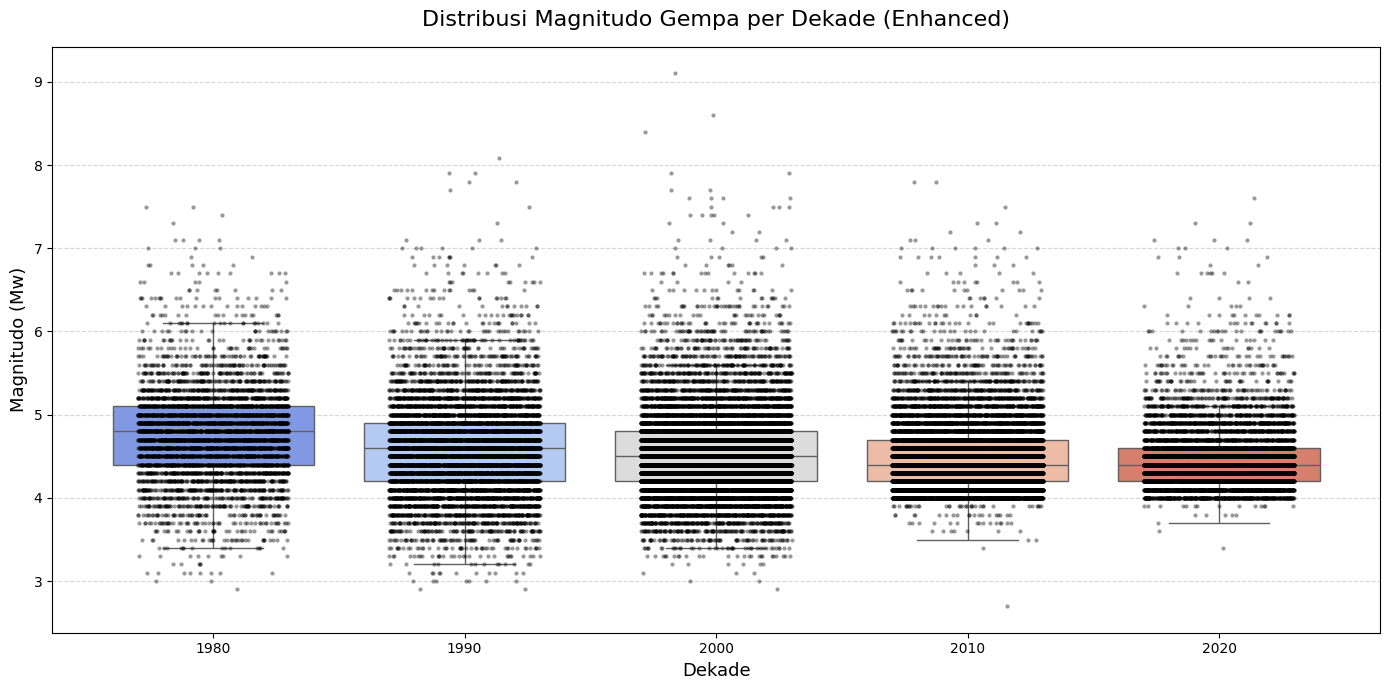

In [28]:
#3. Boxplot per dekade

# Gabungkan kembali kolom menjadi datetime
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Buat kolom dekade
df['dekade'] = (df['year'] // 10) * 10

plt.figure(figsize=(14, 7))

# Boxplot dengan palette elegan
sns.boxplot(x='dekade', y='mag', data=df, palette="coolwarm", showfliers=False)

# Tambahkan stripplot untuk jitter point
sns.stripplot(x='dekade', y='mag', data=df, color='black', size=3, jitter=0.3, alpha=0.4)

# Median line per dekade
medians = df.groupby('dekade')['mag'].median().values
for xtick, median in enumerate(medians):
    plt.plot([xtick - 0.2, xtick + 0.2], [median, median], color='yellow', lw=3)

# Styling
plt.title("Distribusi Magnitudo Gempa per Dekade (Enhanced)", fontsize=16, pad=15)
plt.xlabel("Dekade", fontsize=13)
plt.ylabel("Magnitudo (Mw)", fontsize=13)

plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotation tambahan (opsional, kalau mau kasih highlight tertentu)
# plt.text(3, 7.5, 'Magnitude tinggi di 2000-an', color='red', fontsize=12)

plt.tight_layout()
plt.show()

,mag,depth
Mean,4.539000,85.464000
Median,4.500000,37.700000
Std Dev,0.460000,105.826000
Skewness,1.172000,2.805000
Kurtosis,3.786000,8.824000


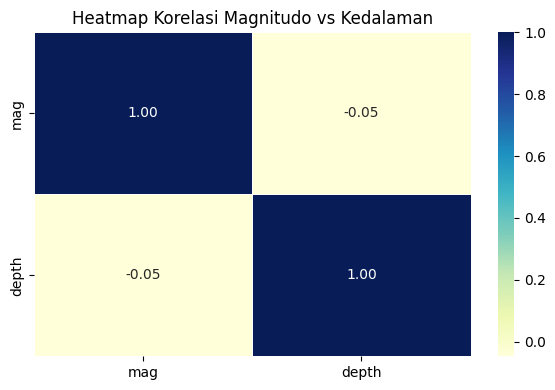

In [29]:
#4. Statistik deskriptif

# Buat dataframe statistik deskriptif
stats = pd.DataFrame({
    'Mean': df[['mag', 'depth']].mean(),
    'Median': df[['mag', 'depth']].median(),
    'Std Dev': df[['mag', 'depth']].std(),
    'Skewness': df[['mag', 'depth']].skew(),
    'Kurtosis': df[['mag', 'depth']].kurtosis()
})

# Bulatkan angka biar rapi
stats = stats.T.round(3)

# Tampilkan tabel dengan styling warna gradien
styled_stats = stats.style.background_gradient(cmap='YlOrBr').set_caption("Statistik Deskriptif Gempa Bumi di Indonesia")
display(styled_stats)

# Heatmap korelasi
plt.figure(figsize=(6, 4))
correlation = df[['mag', 'depth']].corr()
sns.heatmap(correlation, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Magnitudo vs Kedalaman')
plt.tight_layout()
plt.show()

# # Optional: Simpan ke Excel
# stats.to_excel("statistik_deskriptif_gempa.xlsx")
# print("✅ File statistik_deskriptif_gempa.xlsx berhasil disimpan.")


In [30]:
# Simpan hasil feature engineering
df.to_csv('seismic_gap_features.csv', index=False)
print("✅ Dataset hasil feature engineering berhasil disimpan sebagai 'seismic_gap_features.csv'")

✅ Dataset hasil feature engineering berhasil disimpan sebagai 'seismic_gap_features.csv'
